In [1]:
%load_ext nvcc4jupyter

from nvcc4jupyter import set_defaults
set_defaults(compiler_args='-arch=sm_100a -Xptxas=-v')

Source files will be saved in "/tmp/tmpwtniqk_9".


Latency: if an instruction $I$, with latency $l$ takes in a tuple of input registers $(x_1,x_2,..x_n)$ and an output register $x$ then when we issue this at clock cycle $c$:
- First, the instruction $I$ is fetched from instruction memory. it decodes it to understand what are input and output registers (register model here :)) Often, a register file has enough read ports such that for most instructions even if $x_1 = x_2 = ... x_n$ (all operands are equal) it is still possible to read them at once, (not always true).
- Then, the values of the input registers are passed to the execution units, and crucially, at this point the input registers are now free to be read by any other instruction on the next clock cycle.
ALL of the above happens at clock cycle $c$ 

At clock cycles $(c+1)$ to $c+l$ The ALU or whatnot is going to perform the operation of the instruction, (This is when the instruction is in flight, so a total of $l$ clock cycles is the latency) (indeed depending on the instruction, there may be overlap between compute and writeback stages and some concept called latch) [https://www.youtube.com/watch?v=yauQ7o1ZAAw] but nevertheless we move on. 

at clock cycle $c+l$ we do a writeback to $x$ via a write port to the register file. so if you want to use the register $x$ after this instruction was issued at clock cycle $c$, you can use it exactly at clock cycle $c+l+1$ onwards

Throughput: The throughput of an instruction $I$ is essentially some time you need to wait before you can ISSUE any other instruction $I'$ given the operands or result registers that we issue $I'$ does not contain the output register held by the previous issue of $I$ (no data dependency), this is also sometimes called theoretical throughput. The reason I said "some time" instead of "clock cycle" was that for a scalar processor, the throughput of any instruction is one clock cycle. For a superscalar processor, one can issue many instructions per clock cycle.

Memory Bandwith: The gb/s of data that can flow from the main RAM to the processor. one can use the clock speed of a processor to get comparisions between bandwidth rate and latency and throughput. 

The gpu has a significantly higher instruction throughput and memory bandwidth versus a comparable cpu, a cpu designed to have high performance for a sequences of process called thread, and can run $O(10)$ of them in paralell, however, a gpu, can run $\ge O(1000)$ such threads in paralell, amortizing the slower single thread performance. 

The gpu dedicates more transistors to data processing (like floating point ops) and thereby uses compute instead of complex and large data caching and control flow, to hide latency of memory access. 

Both gpus and cpus have become paralell systems, and hence one would like a compiled program to be compatable and have performance scale as the number of cores scale. Hence cuda gives us three key abstractions, a heirachy of: thread groups, shared memories, barrier synchronization (which is like a checkpoint on a thread group, they all have to arrive there, perhaps at different speeds, but everyone has to wait until everyone else has arrived). 

Indeed, threads within a block, give us fine grained data and thread paralellism. that is, threads within a block co-operative solve a sub-problem, however, different thread-blocks must have completely independent tasks, giving us coarse data paralellism and task paralellism, to that end, different blocks can be scheduled on different SMs in any order, and any combination of concurrent and sequential, and the runtime system of the gpu takes care of this scheduling, hence scaling the same program to newer gpus with perf increase seamlessly. 

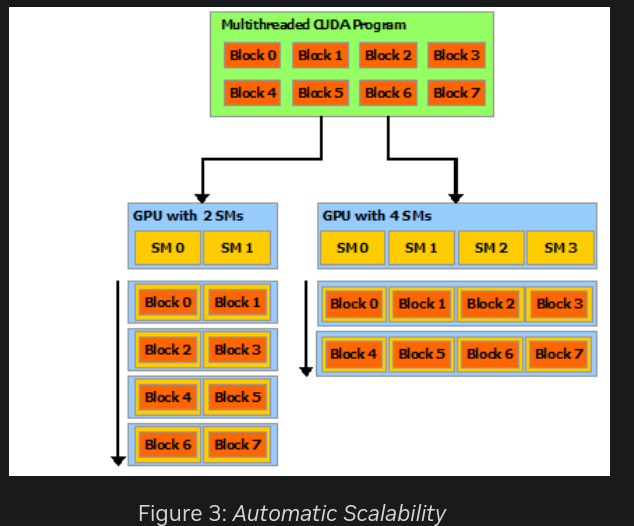


##### GPC's are the new SMs, but they go brr more! 

Roughly speaking, a threadblock is stadard to have about 1024 or 4*1024 (but I think this is pushing it) threads in it, and so if you think about it, the largest unit of co-operative paralellism, (there was no barrier synchronization between different thread blocks of a grid) was 1024 threads. Remember that is was the case that one must be able to assign tasks to different threadblocks, and there could not be ANY DEPENDENCY, in terms of order, in terms of data, or anything else. So for example, a very large reduction, could not be done efficently in a single kernel, let $B = 1024$, $TM$ an optimal sub-reduction size that a single thread could do, then if you had like $N = K\cdot B\cdot TM$ for some large $K$ the length of the reduction array, you could do $K$ partial reductions, each of size $B\times TM$ and store it, and then then launch another kernel to finish the $K$ reductions left over. 

Now, this independence is moved up to a group  of (basically 8) threadblocks called clusters, which are to be assigned tasks that FULLY INDEPENDENT, and these clusters are allocated to physically close groups of SMs called GPC's (graphics processing clusters). 

Indeed, there is barrier synchronization and distributed shared memory, between threadblocks of the same cluster, effectively increasing the size of the largest co-operative paralell unit by $8$ times. 

##### More notes: 
For a particular thread block, the `__synchthreads()` is supposed to a lightweight barrier, and the shared memory, close to the SM, to be low latency like the l1 cache.
For finer threadgroup barriers and more control, there is the new *co-operative groups API* and also the *cluster group API* gives us a lot of stuff about clusters, but now, lets write the simplest vecadd kernel

In [18]:
%%cuda -t

#include<cuda_runtime.h>
#include<cuda.h> 
#include<stdio.h> 
#include<stdlib.h> 


constexpr int N = 4096*4096; 
constexpr int TN = 1; 
constexpr int BN = 1024;
constexpr int work_per_block = BN*TN; 
constexpr int GN = N/work_per_block;

__global__ void vecadd (float*A, float*B, float*C)
{
  
  uint idx = (blockIdx.x*work_per_block) + threadIdx.x*TN;

  if (idx < N) {
    C[idx] = A[idx] + B[idx];
  }
}

int main()
{
  size_t size = N*sizeof(float);
  
  float *A_h = (float*) malloc(size);
  float *B_h = (float*) malloc(size); 
  float *C_h = (float*) malloc(size); 
  
  for (int i = 0; i < N; i++)
  {
    A_h[i] = 1.0f; 
    B_h[i] = 2.0f; 
    C_h[i] = 0.0f; 
  }
  
  float* A_d, *B_d, *C_d; 
  cudaMalloc(&A_d, size);
  cudaMalloc(&B_d, size); 
  cudaMalloc(&C_d, size); 

  cudaMemcpy(A_d, A_h, size, cudaMemcpyHostToDevice);
  cudaMemcpy(B_d, B_h, size, cudaMemcpyHostToDevice);
  cudaMemcpy(C_d, C_h, size, cudaMemcpyHostToDevice);

  vecadd<<<GN, BN>>>(A_d, B_d, C_d);
  

  cudaDeviceSynchronize();
  

  cudaMemcpy(C_h, C_d, size, cudaMemcpyDeviceToHost);

  
  for (int i = 0; i < N; i++)
  {
    if (C_h[i] != 3.0f)
    {
     
      printf("Error at index %d, expected %f, got %f\n", i, 3.0f, C_h[i]);
      break;
    }
    
  }
    for (int i = 0; i < 100000; i++)
  {
    printf("%f ,", C_h[i]);
  }

  // Clean up memory
  free(A_h);
  free(B_h);
  free(C_h);
  cudaFree(A_d);
  cudaFree(B_d);
  cudaFree(C_d);
  
  return 0;
}

681 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%cuda --compiler-args "--optimize 3"

#include<cuda_runtime.h>
#include<cuda.h> 
#include<stdio.h> 
#include<stdlib.h> 

// Error checking macro
#define CHECK_CUDA_ERROR(val) check((val), #val, __FILE__, __LINE__)

void check(cudaError_t err, const char* const func, const char* const file, const int line) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Runtime Error at %s:%d in %s: %s\n",
                file, line, func, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}


constexpr int N = 4096*4096; 
constexpr int TN = 1; 
constexpr int BN = 1024;
constexpr int work_per_block = BN*TN; 
constexpr int GN = N/work_per_block;

__global__ void vecadd (float*A, float*B, float*C)
{
  
  uint idx = (blockIdx.x*work_per_block) + threadIdx.x*TN;

  if (idx < N) {
    C[idx] = A[idx] + B[idx];
  }
}

int main()
{
  size_t size = N*sizeof(float);
  
  float *A_h = (float*) malloc(size);
  float *B_h = (float*) malloc(size); 
  float *C_h = (float*) malloc(size); 
  
  for (int i = 0; i < N; i++)
  {
    A_h[i] = 1.0f; 
    B_h[i] = 2.0f; 
    C_h[i] = 0.0f; 
  }
  
  float* A_d, *B_d, *C_d; 
  CHECK_CUDA_ERROR(cudaMalloc(&A_d, size));
  CHECK_CUDA_ERROR(cudaMalloc(&B_d, size)); 
  CHECK_CUDA_ERROR(cudaMalloc(&C_d, size)); 

  CHECK_CUDA_ERROR(cudaMemcpy(A_d, A_h, size, cudaMemcpyHostToDevice));
  CHECK_CUDA_ERROR(cudaMemcpy(B_d, B_h, size, cudaMemcpyHostToDevice));
  CHECK_CUDA_ERROR(cudaMemcpy(C_d, C_h, size, cudaMemcpyHostToDevice));

  // --- CUDA Timer Implementation Start ---
  cudaEvent_t start, stop;
  float elapsed_time_ms;

  CHECK_CUDA_ERROR(cudaEventCreate(&start));
  CHECK_CUDA_ERROR(cudaEventCreate(&stop));

  // Record the start event
  CHECK_CUDA_ERROR(cudaEventRecord(start, 0)); // 0 is the default stream

  // Launch the kernel
  vecadd<<<GN, BN>>>(A_d, B_d, C_d);
  
  // Record the stop event
  CHECK_CUDA_ERROR(cudaEventRecord(stop, 0));

  // Synchronize the stop event and calculate the elapsed time
  CHECK_CUDA_ERROR(cudaEventSynchronize(stop));
  CHECK_CUDA_ERROR(cudaEventElapsedTime(&elapsed_time_ms, start, stop));
  
  printf("Kernel execution time: %.3f ms\n", elapsed_time_ms);
  
  // Clean up events
  CHECK_CUDA_ERROR(cudaEventDestroy(start));
  CHECK_CUDA_ERROR(cudaEventDestroy(stop));
  // --- CUDA Timer Implementation End ---
  

  // Note: cudaDeviceSynchronize() is redundant here because cudaEventSynchronize(stop) 
  // already ensures the kernel and event recording are complete.
  // cudaDeviceSynchronize(); 
  

  CHECK_CUDA_ERROR(cudaMemcpy(C_h, C_d, size, cudaMemcpyDeviceToHost));

  int error_count = 0;
  for (int i = 0; i < N; i++)
  {
    if (C_h[i] != 3.0f)
    {
     
      printf("Error at index %d, expected %f, got %f\n", i, 3.0f, C_h[i]);
      error_count++;
      break;
    }
    
  }
  
  if (error_count == 0) {
      printf("Verification successful: All elements are 3.0\n");
  }

  // Printing a large number of elements (100000) can cause issues or slow down the output
  // I'll limit it to a few to show the result
  printf("\nFirst 10 results:\n");
  for (int i = 0; i < 10; i++)
  {
    printf("%f ,", C_h[i]);
  }
  printf("...\n");

  // Clean up memory
  free(A_h);
  free(B_h);
  free(C_h);
  CHECK_CUDA_ERROR(cudaFree(A_d));
  CHECK_CUDA_ERROR(cudaFree(B_d));
  CHECK_CUDA_ERROR(cudaFree(C_d));
  
  return 0;
}

Kernel execution time: 16.459 ms
Verification successful: All elements are 3.0

First 10 results:
3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,3.000000 ,...



so for clustered launches one has a few rules: 
- number of threads per block is max 1024 and is ideal nonetheless. 
- number of thread blocks per cluster is a max of 8. 
- for compatability reasons, the grid dim is still decided by number of thread blocks and not number of clusters, hence the number of thread blocks in a grid must be a multiple of the number of the number of blocks in a cluster, cuase really we are launching a grid of clusters. 



In [20]:
%%cuda --compiler-args "--optimize 3"

#include<cuda_runtime.h>
#include<cuda.h> 
#include<stdio.h> 
#include<stdlib.h> 
#include<time.h> // Added for random init and CPU timing
#include<math.h> // Added for fabs in comparison

// Error checking macro
#define CHECK_CUDA_ERROR(val) check((val), #val, __FILE__, __LINE__)

void check(cudaError_t err, const char* const func, const char* const file, const int line) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Runtime Error at %s:%d in %s: %s\n",
                file, line, func, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}

constexpr int n_blocks_per_grid = 128; 
constexpr int n_blocks_per_cluster = 8; //#keep this fixed 
constexpr int n_threads_per_block = 1024; //#keep this fixed

constexpr int M = 1024; 
constexpr int N = 1024; 
constexpr int K = 1024; 

// Host-side CPU Matrix Multiplication for verification (C = A * B)
void matmul_cpu(const float *A, const float *B, float *C_cpu, int m, int n, int k)
{
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < n; j++)
        {
            float sum = 0.0f;
            for (int l = 0; l < k; l++)
            {
                // A is M x K (A[i*k + l]), B is K x N (B[l*n + j])
                sum += A[i * k + l] * B[l * n + j];
            }
            C_cpu[i * n + j] = sum; // C is M x N
        }
    }
}

// Host-side Result Comparison
void check_result(const float *C_h, const float *C_cpu, size_t size)
{
    int errors = 0;
    const float tolerance = 1e-3f;
    for (size_t i = 0; i < size; i++)
    {
        if (fabs(C_h[i] - C_cpu[i]) > tolerance)
        {
            if (errors < 5) // Print only the first few errors
            {
                fprintf(stderr, "Mismatch at index %zu: GPU=%f, CPU=%f\n", i, C_h[i], C_cpu[i]);
            }
            errors++;
        }
    }
    
    if (errors > 0)
    {
        fprintf(stderr, "\nVerification FAILED! Total errors: %d\n", errors);
    }
    else
    {
        printf("\nVerification PASSED!\n");
    }
}


__global__ void kernel(float *A, float*B, float*C)
{
    
}


int main ()
{

  size_t size_A = M*K*sizeof(float); 
  size_t size_B = K*N*sizeof(float); 
  size_t size_C = M*N*sizeof(float); 

  float *A_h = (float*) malloc(size_A);
  float *B_h = (float*) malloc(size_B); 
  float *C_h = (float*) malloc(size_C); 
  float *C_cpu = (float*) malloc(size_C); 
  
  if (!A_h || !B_h || !C_h || !C_cpu)
  {
      fprintf(stderr, "Host memory allocation failed!\n");
      exit(EXIT_FAILURE);
  }

  // Random Initialization
  srand(time(NULL)); 
  for (int i = 0; i < M*K; i++) // Init A (M x K)
  {
    A_h[i] = (float)rand() / ((float)RAND_MAX*10.0f); 
  }
  for (int i = 0; i < K*N; i++) // Init B (K x N)
  {
    B_h[i] = (float)rand() / ((float)RAND_MAX*10.0f); 
  }
  for (int i = 0; i < M*N; i++) // Init C and C_cpu (M x N)
  {
    C_h[i] = 0.0f; 
    C_cpu[i] = 0.0f;
  }
  
  float* A_d, *B_d, *C_d; 
  CHECK_CUDA_ERROR(cudaMalloc(&A_d, size_A));
  CHECK_CUDA_ERROR(cudaMalloc(&B_d, size_B)); 
  CHECK_CUDA_ERROR(cudaMalloc(&C_d, size_C)); 

  CHECK_CUDA_ERROR(cudaMemcpy(A_d, A_h, size_A, cudaMemcpyHostToDevice));
  CHECK_CUDA_ERROR(cudaMemcpy(B_d, B_h, size_B, cudaMemcpyHostToDevice));
  CHECK_CUDA_ERROR(cudaMemcpy(C_d, C_h, size_C, cudaMemcpyHostToDevice));
  
  dim3 TPB(n_threads_per_block,1,1);
  dim3 BPG(n_blocks_per_grid,1,1);
  
  cudaLaunchConfig_t config = {0};
  config.gridDim = BPG;
  config.blockDim = TPB; 
  cudaLaunchAttribute attribute[1];
  attribute[0].id = cudaLaunchAttributeClusterDimension;
  attribute[0].val.clusterDim.x = n_blocks_per_cluster; //# Cluster size in X-dimension
  attribute[0].val.clusterDim.y = 1;
  attribute[0].val.clusterDim.z = 1;
  config.attrs = attribute;
  config.numAttrs = 1;

  // CUDA Event Timer Setup
  cudaEvent_t start, stop;
  CHECK_CUDA_ERROR(cudaEventCreate(&start));
  CHECK_CUDA_ERROR(cudaEventCreate(&stop));

 
  CHECK_CUDA_ERROR(cudaEventRecord(start, 0));

  cudaLaunchKernelEx(&config, kernel, A_d, B_d, C_d);


  CHECK_CUDA_ERROR(cudaGetLastError()); 

  CHECK_CUDA_ERROR(cudaEventRecord(stop, 0));
  CHECK_CUDA_ERROR(cudaEventSynchronize(stop));

  float milliseconds = 0;
  CHECK_CUDA_ERROR(cudaEventElapsedTime(&milliseconds, start, stop));
  printf("GPU Kernel time: %f ms\n", milliseconds);

  CHECK_CUDA_ERROR(cudaMemcpy(C_h, C_d, size_C, cudaMemcpyDeviceToHost));

  printf("Running CPU verification...\n");
  clock_t cpu_start = clock();
  matmul_cpu(A_h, B_h, C_cpu, M, N, K);
  clock_t cpu_stop = clock();
  double cpu_time = (double)(cpu_stop - cpu_start) * 1000.0 / CLOCKS_PER_SEC;
  printf("CPU Matmul time: %f ms\n", cpu_time);

  check_result(C_h, C_cpu, M*N);


  free(A_h);
  free(B_h);
  free(C_h);
  free(C_cpu);
  
  CHECK_CUDA_ERROR(cudaFree(A_d));
  CHECK_CUDA_ERROR(cudaFree(B_d));
  CHECK_CUDA_ERROR(cudaFree(C_d));
  
  CHECK_CUDA_ERROR(cudaEventDestroy(start));
  CHECK_CUDA_ERROR(cudaEventDestroy(stop));

  return 0;
}

Mismatch at index 0: GPU=0.000000, CPU=2.655185
Mismatch at index 1: GPU=0.000000, CPU=2.583979
Mismatch at index 2: GPU=0.000000, CPU=2.593668
Mismatch at index 3: GPU=0.000000, CPU=2.618982
Mismatch at index 4: GPU=0.000000, CPU=2.497476

Verification FAILED! Total errors: 1048576
GPU Kernel time: 0.161088 ms
Running CPU verification...
CPU Matmul time: 8004.478000 ms



##### ILP (single thread matters too)

So as usual, my relucantly lazy brain only understands thing when I step away from the computer and math it out. It is a common practise in matmul threadiling (Where one computes a tiny tile with each thread) to put the k loop on the outside. I just kinda blindly did it, cause as usual when I see a term like ISTRUCTION LEVEL PARALELLISM I feel like "I gotta go down a rabbit hole whatever I'll check it out later" people should much rather explain what something is than use terms, but I guess thats hard to do for every term. Never mind.

Imagine you're using a single thread to do a TMxTM matmul. Indeed the FMA instruction (this is cuda core stuff only) has a latency greater than one clock cycle. suppose its l clock cycles. Now if your i,j loops are on the outside and the k loop is on the inside, then remember that for each k in TM, as you loop over, you're FMA'ing to the same output element c[i][j]. So you have to wait $l$ clock cycles before you can deploy the same FMA over $c[i][j]$ again. Roughly speaking, each "inner product" (looping over k) then takes about $TM*l$ clock cycles, cause you deploy one every $l$ cycles only. So for the full TMxTM tile of $C$, we have roughly O(TM^3 * l) clock cycles. 

But remember that an FMA instruction has throughput of every clock cyvle, you can deploy one every clock cycle given that you're giving output to a different (unclaimed) element. so, if you put the $k$ loop on the outside, and the i,j loops on the inside, you're hitting the full $C$ tile once before returning to the first deployed element, letting you fill those ide gaps. Ideally its even better if TM is optimized such that: 






In [34]:
%%cuda --compiler-args "-O0 -Xptxas -O0"
#include <cuda_runtime.h>
#include <cuda.h> 
#include <stdio.h> 
#include <stdlib.h> 
#include <math.h>

// --- USER DEFINABLE PARAMETERS ---
// TM: Tile Matrix Dimension (TM x TM x TM matrix multiply fragment)
// Must be small enough for 3 * TM*TM floats to fit into thread registers (e.g., TM <= 8 is usually safe)
#define TM 4

// N_REPS: Number of times the TMxTM matmul is repeated. 
// A high number (e.g., 10 million) is needed to amplify the cycle difference 
// into a measurable millisecond time difference for the CUDA Event timer.
#define N_REPS 25000000

// --- Constants derived from user input ---
constexpr int MATRIX_SIZE = TM * TM;
constexpr int NUM_FMAS_PER_MATMUL = TM * TM * TM;
constexpr long long TOTAL_FMAS = (long long)NUM_FMAS_PER_MATMUL * N_REPS;
constexpr long long TOTAL_FLOPS = TOTAL_FMAS * 2; // FMA is 2 FLOPS (Multiply + Add)

// Helper function to check CUDA errors
#define CHECK_CUDA_ERROR(val) check((val), #val, __FILE__, __LINE__)
void check(cudaError_t err, const char* func, const char* file, int line) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s in %s at line %d, function %s\n", 
                cudaGetErrorString(err), file, line, func);
        exit(EXIT_FAILURE);
    }
}

// ====================================================================
// KERNEL A: Dependent FMA Chain (I-J-K Loop Order)
// Measures pipeline latency, as C[i][j] depends on the previous C[i][j].
// ====================================================================
__global__ void benchmark_k_inner(float* C_out, const float* A_in, const float* B_in, int N_reps) {
    // Force register allocation using local arrays.
    // The compiler will aggressively try to keep these arrays in registers.
    float A_reg[TM][TM]; 
    float B_reg[TM][TM];
    float C_acc[TM][TM] = {0.0f};

    // --- INITIAL LOAD (Anti-Optimization Step 1) ---
    // Load data from global memory just once into registers 
    // (This ensures the computation is non-trivial and the data is "live")
    for (int i = 0; i < TM; i++) {
        for (int j = 0; j < TM; j++) {
            // Use A_in and B_in addresses based on thread ID for unique initial values
            A_reg[i][j] = A_in[i * TM + j] * (threadIdx.x + 1);
            B_reg[i][j] = B_in[i * TM + j] * (threadIdx.x + 1);
        }
    }

    // --- CORE REPETITION LOOP (The Measurement Loop) ---
    for (int r = 0; r < N_reps; r++) {
        // --- Inner Loops: I-J-K order (K is innermost) ---
        // K-loop creates a dependent chain on C_acc[i][j]
        #
        for (int i = 0; i < TM; i++) {
            
            for (int j = 0; j < TM; j++) {
                // Inner loop is K: C[i,j] is the single accumulator (dependent FMA chain)
                
                for (int k = 0; k < TM; k++) {
                    C_acc[i][j] = (A_reg[i][k]*B_reg[k][j]) + C_acc[i][j];  
                }
            }
        }
    }

    // --- FINAL WRITE (Anti-Optimization Step 2) ---
    // Write back the final accumulated result to global memory
    for (int i = 0; i < TM; i++) {
        for (int j = 0; j < TM; j++) {
            C_out[i * TM + j] = C_acc[i][j];
        }
    }
}

// ====================================================================
// KERNEL B: Independent FMA Stream (K-Outer Loop Order)
// Measures pipeline throughput, as each FMA in the inner loops is independent.
// ====================================================================
__global__ void benchmark_k_outer(float* C_out, const float* A_in, const float* B_in, int N_reps) {
    // Force register allocation 
    float A_reg[TM][TM]; 
    float B_reg[TM][TM];
    float C_acc[TM][TM] = {0.0f};

    // --- INITIAL LOAD ---
    for (int i = 0; i < TM; i++) {
        for (int j = 0; j < TM; j++) {
            A_reg[i][j] = A_in[i * TM + j] * (threadIdx.x + 1);
            B_reg[i][j] = B_in[i * TM + j] * (threadIdx.x + 1);
        }
    }

    // --- CORE REPETITION LOOP (The Measurement Loop) ---
    for (int r = 0; r < N_reps; r++) {
        // --- Inner Loops: K-I-J order (I and J are innermost) ---
        // I/J loops create a stream of INDEPENDENT FMAs writing to different C[i,j] registers
        
        for (int k = 0; k < TM; k++) { // K is outermost loop in the calculation
            
            for (int i = 0; i < TM; i++) {
                
                for (int j = 0; j < TM; j++) {
                    // Independent FMA: C[i,j] accumulators are distinct registers.
                    C_acc[i][j] = (A_reg[i][k]*B_reg[k][j]) + C_acc[i][j]; 
                }
            }
        }
    }

    // --- FINAL WRITE (Anti-Optimization Step 2) ---
    // Write back the final accumulated result to global memory
    for (int i = 0; i < TM; i++) {
        for (int j = 0; j < TM; j++) {
            C_out[i * TM + j] = C_acc[i][j];
        }
    }
}

// ====================================================================
// HOST CODE (Main Benchmarking Logic)
// ====================================================================
int main() {
    printf("--- NVIDIA FMA Pipeline Microbenchmark ---\n");
    printf("Matrix Fragment Size (TM): %d x %d\n", TM, TM);
    printf("Total Repetitions (N_REPS): %d\n", N_REPS);
    printf("Total FMA Operations (per kernel): %lld\n", TOTAL_FMAS);
    printf("Total Theoretical FLOPS (per kernel): %lld\n", TOTAL_FLOPS);
    printf("----------------------------------------------------\n");

    size_t size = MATRIX_SIZE * sizeof(float);
    
    // --- 1. Host Memory Allocation and Initialization ---
    float *A_h = (float*)malloc(size);
    float *B_h = (float*)malloc(size); 
    float *C_h_inner = (float*)malloc(size);
    float *C_h_outer = (float*)malloc(size); 
    
    for (int i = 0; i < MATRIX_SIZE; i++) {
        A_h[i] = ((float)(i % 10) + 0.1f)/1000.0; // Non-zero, non-trivial data
        B_h[i] = ((float)((i + 5) % 10) + 0.2f)/1000.0; 
    }
    
    // --- 2. Device Memory Allocation and Transfer ---
    float *A_d, *B_d, *C_d_inner, *C_d_outer; 
    CHECK_CUDA_ERROR(cudaMalloc(&A_d, size));
    CHECK_CUDA_ERROR(cudaMalloc(&B_d, size)); 
    CHECK_CUDA_ERROR(cudaMalloc(&C_d_inner, size)); 
    CHECK_CUDA_ERROR(cudaMalloc(&C_d_outer, size)); 

    CHECK_CUDA_ERROR(cudaMemcpy(A_d, A_h, size, cudaMemcpyHostToDevice));
    CHECK_CUDA_ERROR(cudaMemcpy(B_d, B_h, size, cudaMemcpyHostToDevice));

    // --- 3. CUDA Event Setup for Timing ---
    cudaEvent_t start, stop;
    CHECK_CUDA_ERROR(cudaEventCreate(&start));
    CHECK_CUDA_ERROR(cudaEventCreate(&stop));
    
    // --- Configuration: 1 Block, 1 Thread ---
    dim3 grid(1, 1);
    dim3 block(1, 1);

    float elapsed_ms_inner, elapsed_ms_outer;

    // ----------------------------------------------------
    // BENCHMARK 1: K-INNER (Dependent)
    // ----------------------------------------------------
    printf("Running Kernel A (K-INNER / Dependent FMA)...\n");
    
    // WARMUP (CRITICAL for discarding launch overhead and compiling JIT)
    benchmark_k_inner<<<grid, block>>>(C_d_inner, A_d, B_d, N_REPS / 100); 
    CHECK_CUDA_ERROR(cudaDeviceSynchronize()); 
    
    CHECK_CUDA_ERROR(cudaEventRecord(start, 0));
    benchmark_k_inner<<<grid, block>>>(C_d_inner, A_d, B_d, N_REPS);
    CHECK_CUDA_ERROR(cudaEventRecord(stop, 0));
    
    CHECK_CUDA_ERROR(cudaEventSynchronize(stop));
    CHECK_CUDA_ERROR(cudaEventElapsedTime(&elapsed_ms_inner, start, stop));
    
    double achieved_gflops_inner = (double)TOTAL_FLOPS / (elapsed_ms_inner * 1e6);
    printf("  Time: %.3f ms\n", elapsed_ms_inner);
    printf("  Achieved GFLOPS: %.2f GFLOPS/s\n", achieved_gflops_inner);
    
    // ----------------------------------------------------
    // BENCHMARK 2: K-OUTER (Independent)
    // ----------------------------------------------------
    printf("\nRunning Kernel B (K-OUTER / Independent FMA)...\n");

    // WARMUP
    benchmark_k_outer<<<grid, block>>>(C_d_outer, A_d, B_d, N_REPS / 100); 
    CHECK_CUDA_ERROR(cudaDeviceSynchronize()); 

    CHECK_CUDA_ERROR(cudaEventRecord(start, 0));
    benchmark_k_outer<<<grid, block>>>(C_d_outer, A_d, B_d, N_REPS);
    CHECK_CUDA_ERROR(cudaEventRecord(stop, 0));
    
    CHECK_CUDA_ERROR(cudaEventSynchronize(stop));
    CHECK_CUDA_ERROR(cudaEventElapsedTime(&elapsed_ms_outer, start, stop));
    
    double achieved_gflops_outer = (double)TOTAL_FLOPS / (elapsed_ms_outer * 1e6);
    printf("  Time: %.3f ms\n", elapsed_ms_outer);
    printf("  Achieved GFLOPS: %.2f GFLOPS/s\n", achieved_gflops_outer);
    
    // --- 4. Final Verification and Cleanup ---

    // Anti-Optimization Step 3: Read one result back to prove the computation was necessary
    CHECK_CUDA_ERROR(cudaMemcpy(C_h_inner, C_d_inner, sizeof(float), cudaMemcpyDeviceToHost));

    printf("\nVerification: Final calculated C[0][0] (Kernel A) = %f (Value must be computed to prevent optimization)\n", C_h_inner[0]);
    printf("\n--- Result Comparison ---\n");
    printf("Kernel B (Independent) is %.2fX faster than Kernel A (Dependent)\n", 
           elapsed_ms_inner / elapsed_ms_outer);
    printf("-------------------------\n");

    // Clean up memory and events
    free(A_h);
    free(B_h);
    free(C_h_inner);
    free(C_h_outer);
    CHECK_CUDA_ERROR(cudaFree(A_d));
    CHECK_CUDA_ERROR(cudaFree(B_d));
    CHECK_CUDA_ERROR(cudaFree(C_d_inner));
    CHECK_CUDA_ERROR(cudaFree(C_d_outer));
    CHECK_CUDA_ERROR(cudaEventDestroy(start));
    CHECK_CUDA_ERROR(cudaEventDestroy(stop));
    
    return 0;
}


--- NVIDIA FMA Pipeline Microbenchmark ---
Matrix Fragment Size (TM): 4 x 4
Total Repetitions (N_REPS): 25000000
Total FMA Operations (per kernel): 1600000000
Total Theoretical FLOPS (per kernel): 3200000000
----------------------------------------------------
Running Kernel A (K-INNER / Dependent FMA)...
  Time: 12053.963 ms
  Achieved GFLOPS: 0.27 GFLOPS/s

Running Kernel B (K-OUTER / Independent FMA)...
  Time: 12052.312 ms
  Achieved GFLOPS: 0.27 GFLOPS/s

Verification: Final calculated C[0][0] (Kernel A) = 512.000000 (Value must be computed to prevent optimization)

--- Result Comparison ---
Kernel B (Independent) is 1.00X faster than Kernel A (Dependent)
-------------------------



### Fuck cloud cards

OH VAST AI WE ARE OPTIMIZE ORGANIZE AND ORIENT THE WORLDS COMPUTATION BUT I CANT GET A CHEAP 50 series card
with profiling enableled even if I am willing to pay 4x the hourly rate so fuck that shit. There is a small speedup in kernel B but I cant tell you shit beyond that. if only I could see the instruction throughput. 
I may need to inspect the Saas dump on a single looped run to see if the instructions are actually spawning in a different order, or if I am missing removing some more compiler optimization. Okay as I increase reps It seems like I am getting kernel B 1 millisecond consistenntly faster. More importantly the difference in speed does seem to scale linearly with the number of reps... idk. Will have to see the SASS someday. 

Actually fuck gemini I literally paid for pro and it wrote the most blursed code ever. mutliplying by thread idx? what the fuck? look at the kernel lol 

In [15]:
%%cuda --compiler-args "-O0 -Xptxas -O0"
//#okay lets write some simple shit
#include <stdio.h> 
#include<stdlib.h> 
#include<cuda.h> 
#include<cuda_runtime.h>

constexpr int N = 4; 
constexpr int reps = 10000000;


__global__ void inner_k(float *A, float *B, float *C) {

  float A_reg[N*N];
  float B_reg[N*N];
  float C_reg[N*N] = {0.0f};
  uint t = threadIdx.x; 

  for (int i = 0; i < N*N; i++) {
      A_reg[i] = A[t + i];
      B_reg[i] = B[t + i];
  }

  for (int repeat = 0; repeat < reps; repeat++) {
      for (int i = 0; i < N; i++) {
          for (int j = 0; j < N; j++) {
              for (int k = 0; k < N; k++) {
                  C_reg[i*N + j] += A_reg[i*N + k] * B_reg[k*N + j];
              }
          }
      }
  }

  // Write result back
  for (int i = 0; i < N*N; i++) {
      C[i] = C_reg[t + i];
  }
}


int main() {
    //# Host arrays
    float A[N*N], B[N*N], C[N*N];

    //# Init A and B
    for (int i = 0; i < N*N; i++) {
        A[i] = 0.001f;
        B[i] = 0.002f;
    }

    // #Device arrays
    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, N*N*sizeof(float));
    cudaMalloc(&d_B, N*N*sizeof(float));
    cudaMalloc(&d_C, N*N*sizeof(float));

    cudaMemcpy(d_A, A, N*N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N*N*sizeof(float), cudaMemcpyHostToDevice);

    //# Timing events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    inner_k<<<1,1>>>(d_A, d_B, d_C);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Kernel time: %f ms\n", ms);

    // # Copy back result
    cudaMemcpy(C, d_C, N*N*sizeof(float), cudaMemcpyDeviceToHost);

    // #Print output matrix
    printf("C =\n");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            printf("%f ", C[i*N + j]);
        }
        printf("\n");
    }

    // #Cleanup
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Kernel time: 4487.652832 ms
C =
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 



In [17]:
%%cuda --compiler-args "-O0 -Xptxas -O0"
//#okay lets write some simple shit
#include <stdio.h> 
#include<stdlib.h> 
#include<cuda.h> 
#include<cuda_runtime.h>

constexpr int N = 4; 
constexpr int reps = 10000000;


__global__ void inner_k(float *A, float *B, float *C) {

  float A_reg[N*N];
  float B_reg[N*N];
  float C_reg[N*N] = {0.0f};
  uint t = threadIdx.x; 

  for (int i = 0; i < N*N; i++) {
      A_reg[i] = A[t + i];
      B_reg[i] = B[t + i];
  }

  for (int repeat = 0; repeat < reps; repeat++) {
      for (int k = 0; k < N; k++) {
          for (int i = 0; i < N; i++) {
              for (int j = 0; j < N; j++) {
                  C_reg[i*N + j] += A_reg[i*N + k] * B_reg[k*N + j];
              }
          }
      }
  }

  // Write result back
  for (int i = 0; i < N*N; i++) {
      C[i] = C_reg[t + i];
  }
}


int main() {
    //# Host arrays
    float A[N*N], B[N*N], C[N*N];

    //# Init A and B
    for (int i = 0; i < N*N; i++) {
        A[i] = 0.001f;
        B[i] = 0.002f;
    }

    // #Device arrays
    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, N*N*sizeof(float));
    cudaMalloc(&d_B, N*N*sizeof(float));
    cudaMalloc(&d_C, N*N*sizeof(float));

    cudaMemcpy(d_A, A, N*N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N*N*sizeof(float), cudaMemcpyHostToDevice);

    //# Timing events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    inner_k<<<1,1>>>(d_A, d_B, d_C);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Kernel time: %f ms\n", ms);

    // # Copy back result
    cudaMemcpy(C, d_C, N*N*sizeof(float), cudaMemcpyDeviceToHost);

    // #Print output matrix
    printf("C =\n");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            printf("%f ", C[i*N + j]);
        }
        printf("\n");
    }

    // #Cleanup
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Kernel time: 4487.425293 ms
C =
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 
64.000000 64.000000 64.000000 64.000000 



In [ ]:
%%cuda --compiler-args "-O0 -Xptxas -O0"
//#okay lets write some simple shit
#include <stdio.h> 
#include<stdlib.h> 
#include<cuda.h> 
#include<cuda_runtime.h>

constexpr int N = 4; 
constexpr int reps = 1;


__global__ void inner_k(float *A, float *B, float *C) {

  float A_reg[N*N];
  float B_reg[N*N];
  float C_reg[N*N] = {0.0f};
  uint t = threadIdx.x; 

  for (int i = 0; i < N*N; i++) {
      A_reg[i] = A[t + i];
      B_reg[i] = B[t + i];
  }

  for (int repeat = 0; repeat < reps; repeat++) {
      for (int k = 0; k < N; k++) {
          for (int i = 0; i < N; i++) {
              for (int j = 0; j < N; j++) {
                  C_reg[i*N + j] += A_reg[i*N + k] * B_reg[k*N + j];
              }
          }
      }
  }

  // Write result back
  for (int i = 0; i < N*N; i++) {
      C[i] = C_reg[t + i];
  }
}


int main() {
    //# Host arrays
    float A[N*N], B[N*N], C[N*N];

    //# Init A and B
    for (int i = 0; i < N*N; i++) {
        A[i] = 0.01f;
        B[i] = 0.02f;
    }

    // #Device arrays
    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, N*N*sizeof(float));
    cudaMalloc(&d_B, N*N*sizeof(float));
    cudaMalloc(&d_C, N*N*sizeof(float));

    cudaMemcpy(d_A, A, N*N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N*N*sizeof(float), cudaMemcpyHostToDevice);

    //# Timing events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    inner_k<<<1,1>>>(d_A, d_B, d_C);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Kernel time: %f ms\n", ms);

    // # Copy back result
    cudaMemcpy(C, d_C, N*N*sizeof(float), cudaMemcpyDeviceToHost);

    // #Print output matrix
    printf("C =\n");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            printf("%f ", C[i*N + j]);
        }
        printf("\n");
    }

    // #Cleanup
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Kernel time: 0.233088 ms
C =
0.000800 0.000800 0.000800 0.000800 
0.000800 0.000800 0.000800 0.000800 
0.000800 0.000800 0.000800 0.000800 
0.000800 0.000800 0.000800 0.000800 



As you can see in the raw ptx, the inner k one and outer k one are different, the inner k one uses the output register of the previous fma as input to the next fma, while the outer k one doesn't. And yet, there is no speedup from the crude bechnmark... hmm... NEED PROFILER! This is the fma part of the raw SAAS for the outer loop. 

```
        /*1750*/                   FFMA R25, R6, R7, RZ ;                       /* 0x0000000706197223 */
                                                                                /* 0x003fde00000000ff */
        /*1760*/                   FFMA R29, R6, R9, RZ ;                       /* 0x00000009061d7223 */
                                                                                /* 0x003fde00000000ff */
        /*1770*/                   FFMA R31, R6, R11, RZ ;                      /* 0x0000000b061f7223 */
                                                                                /* 0x003fde00000000ff */
        /*1780*/                   FFMA R33, R6, R13, RZ ;                      /* 0x0000000d06217223 */
                                                                                /* 0x003fde00000000ff */
        /*1790*/                   FFMA R45, R14, R7, RZ ;                      /* 0x000000070e2d7223 */
                                                                                /* 0x003fde00000000ff */
        /*17a0*/                   FFMA R46, R14, R9, RZ ;                      /* 0x000000090e2e7223 */
                                                                                /* 0x003fde00000000ff */
        /*17b0*/                   FFMA R6, R14, R11, RZ ;                      /* 0x0000000b0e067223 */
                                                                                /* 0x003fde00000000ff */
        /*17c0*/                   FFMA R47, R14, R13, RZ ;                     /* 0x0000000d0e2f7223 */
                                                                                /* 0x003fde00000000ff */
        /*17d0*/                   FFMA R48, R22, R7, RZ ;                      /* 0x0000000716307223 */
                                                                                /* 0x003fde00000000ff */
        /*17e0*/                   FFMA R49, R22, R9, RZ ;                      /* 0x0000000916317223 */
                                                                                /* 0x003fde00000000ff */
        /*17f0*/                   FFMA R14, R22, R11, RZ ;                     /* 0x0000000b160e7223 */
                                                                                /* 0x003fde00000000ff */
        /*1800*/                   FFMA R22, R22, R13, RZ ;                     /* 0x0000000d16167223 */
                                                                                /* 0x003fde00000000ff */
        /*1810*/                   FFMA R7, R39, R7, RZ ;                       /* 0x0000000727077223 */
                                                                                /* 0x003fde00000000ff */
        /*1820*/                   FFMA R9, R39, R9, RZ ;                       /* 0x0000000927097223 */
                                                                                /* 0x003fde00000000ff */
        /*1830*/                   FFMA R11, R39, R11, RZ ;                     /* 0x0000000b270b7223 */
                                                                                /* 0x003fde00000000ff */
        /*1840*/                   FFMA R13, R39, R13, RZ ;                     /* 0x0000000d270d7223 */
                                                                                /* 0x003fde00000000ff */
        /*1850*/                   FFMA R25, R8, R15, R25 ;                     /* 0x0000000f08197223 */
                                                                                /* 0x003fde0000000019 */
        /*1860*/                   FFMA R29, R8, R17, R29 ;                     /* 0x00000011081d7223 */
                                                                                /* 0x003fde000000001d */
        /*1870*/                   FFMA R31, R8, R19, R31 ;                     /* 0x00000013081f7223 */
                                                                                /* 0x003fde000000001f */
        /*1880*/                   FFMA R33, R8, R21, R33 ;                     /* 0x0000001508217223 */
                                                                                /* 0x003fde0000000021 */
        /*1890*/                   FFMA R45, R16, R15, R45 ;                    /* 0x0000000f102d7223 */
                                                                                /* 0x003fde000000002d */
        /*18a0*/                   FFMA R46, R16, R17, R46 ;                    /* 0x00000011102e7223 */
                                                                                /* 0x003fde000000002e */
        /*18b0*/                   FFMA R6, R16, R19, R6 ;                      /* 0x0000001310067223 */
                                                                                /* 0x003fde0000000006 */
        /*18c0*/                   FFMA R47, R16, R21, R47 ;                    /* 0x00000015102f7223 */
                                                                                /* 0x003fde000000002f */
        /*18d0*/                   FFMA R48, R24, R15, R48 ;                    /* 0x0000000f18307223 */
                                                                                /* 0x003fde0000000030 */
        /*18e0*/                   FFMA R49, R24, R17, R49 ;                    /* 0x0000001118317223 */
                                                                                /* 0x003fde0000000031 */
        /*18f0*/                   FFMA R14, R24, R19, R14 ;                    /* 0x00000013180e7223 */
                                                                                /* 0x003fde000000000e */
        /*1900*/                   FFMA R22, R24, R21, R22 ;                    /* 0x0000001518167223 */
                                                                                /* 0x003fde0000000016 */
        /*1910*/                   FFMA R7, R41, R15, R7 ;                      /* 0x0000000f29077223 */
                                                                                /* 0x003fde0000000007 */
        /*1920*/                   FFMA R9, R41, R17, R9 ;                      /* 0x0000001129097223 */
                                                                                /* 0x003fde0000000009 */
        /*1930*/                   FFMA R11, R41, R19, R11 ;                    /* 0x00000013290b7223 */
                                                                                /* 0x003fde000000000b */
        /*1940*/                   FFMA R13, R41, R21, R13 ;                    /* 0x00000015290d7223 */
                                                                                /* 0x003fde000000000d */
```

And this one for the inner loop
```
        /*14c0*/                   FFMA R12, R43, R31, RZ ;                     /* 0x0000001f2b0c7223 */
                                                                                /* 0x003fde00000000ff */
        /*14d0*/                   FFMA R12, R42, R30, R12 ;                    /* 0x0000001e2a0c7223 */
                                                                                /* 0x003fde000000000c */
        /*14e0*/                   FFMA R12, R41, R29, R12 ;                    /* 0x0000001d290c7223 */
                                                                                /* 0x003fde000000000c */
        /*14f0*/                   FFMA R12, R15, R32, R12 ;                    /* 0x000000200f0c7223 */
                                                                                /* 0x003fde000000000c */
        /*1500*/                   FFMA R13, R43, R25, RZ ;                     /* 0x000000192b0d7223 */
                                                                                /* 0x003fde00000000ff */
        /*1510*/                   FFMA R13, R42, R27, R13 ;                    /* 0x0000001b2a0d7223 */
                                                                                /* 0x003fde000000000d */
        /*1520*/                   FFMA R13, R41, R26, R13 ;                    /* 0x0000001a290d7223 */
                                                                                /* 0x003fde000000000d */
        /*1530*/                   FFMA R13, R15, R28, R13 ;                    /* 0x0000001c0f0d7223 */
                                                                                /* 0x003fde000000000d */
        /*1540*/                   FFMA R14, R43, R21, RZ ;                     /* 0x000000152b0e7223 */
                                                                                /* 0x003fde00000000ff */
        /*1550*/                   FFMA R14, R42, R22, R14 ;                    /* 0x000000162a0e7223 */
                                                                                /* 0x003fde000000000e */
        /*1560*/                   FFMA R14, R41, R23, R14 ;                    /* 0x00000017290e7223 */
                                                                                /* 0x003fde000000000e */
        /*1570*/                   FFMA R14, R15, R24, R14 ;                    /* 0x000000180f0e7223 */
                                                                                /* 0x003fde000000000e */
        /*1580*/                   FFMA R43, R43, R7, RZ ;                      /* 0x000000072b2b7223 */
                                                                                /* 0x003fde00000000ff */
        /*1590*/                   FFMA R43, R42, R8, R43 ;                     /* 0x000000082a2b7223 */
                                                                                /* 0x003fde000000002b */
        /*15a0*/                   FFMA R43, R41, R9, R43 ;                     /* 0x00000009292b7223 */
                                                                                /* 0x003fde000000002b */
        /*15b0*/                   FFMA R15, R15, R20, R43 ;                    /* 0x000000140f0f7223 */

```

Here again we can see the inner loop re-uses the same register on sequenetial computations. 

And yet clearly the inner loop benchmark is almost exactly the same as the outer loop.. one wonders. 


Even running with full optimized flags, the inner loop fmas are still not scheduled to expose ILP. 
check it out. 